# NEUROSYMBOLIC INTEGRATED WITH GNN

In [1]:
# ===== RESTART KERNEL FIRST AND RUN THIS COMPLETE CODE =====
# OPTIMIZED 5-8M PARAMETER MODEL WITH PROGRESS BAR AND EVERY EPOCH RESULTS

# Restart your kernel first, then run this
import sys
import os
import gc
import math
import warnings
import time
from datetime import datetime
warnings.filterwarnings('ignore')

# Safe torch imports
try:
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    print("✅ PyTorch loaded successfully")
except ImportError as e:
    print(f"❌ PyTorch import failed: {e}")
    sys.exit(1)

# Progress bar import
try:
    from tqdm import tqdm
    print("✅ tqdm loaded for progress bars")
except ImportError:
    print("⚠️ tqdm not found, using basic progress")
    class tqdm:
        def __init__(self, iterable=None, total=None, desc="", unit="epoch"):
            self.iterable = iterable if iterable else range(total)
            self.total = total
            self.desc = desc
            self.current = 0
            
        def __iter__(self):
            return self
            
        def __next__(self):
            if self.current >= len(self.iterable):
                raise StopIteration
            value = self.iterable[self.current]
            self.current += 1
            progress = self.current / len(self.iterable) * 100
            print(f"\r{self.desc} [{self.current}/{len(self.iterable)}] {progress:.1f}%", end='', flush=True)
            return value
            
        def set_postfix(self, **kwargs):
            pass

# Safe PyTorch Geometric imports with fallback
try:
    import torch_geometric
    from torch_geometric.nn import HeteroConv, GATConv, SAGEConv
    from torch_geometric.nn import Linear
    print("✅ PyTorch Geometric loaded successfully")
except (ImportError, AttributeError) as e:
    print(f"⚠️ PyTorch Geometric issue: {e}")
    print("🔧 Using fallback Linear layer...")
    Linear = nn.Linear

# Check CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

class OptimizedGNN58M(nn.Module):
    """Optimized 5-8M Parameter GNN for Maximum Accuracy"""
    def __init__(self, sequence_features, problem_features, skill_features,
                 hidden_dim=320, num_layers=5, num_heads=20, dropout=0.16, device='cuda'):
        super(OptimizedGNN58M, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout = dropout
        self.num_heads = num_heads
        self.device = device
        
        # OPTIMIZED input projections - 3x expansion (reduced from 4x)
        self.sequence_input_proj = nn.Sequential(
            nn.Linear(sequence_features, hidden_dim * 3),  # 3x instead of 4x
            nn.BatchNorm1d(hidden_dim * 3),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim * 3, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.GELU()
        ).to(device)
        
        self.problem_input_proj = nn.Sequential(
            nn.Linear(problem_features, hidden_dim * 3),
            nn.BatchNorm1d(hidden_dim * 3),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim * 3, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.GELU()
        ).to(device)
        
        self.skill_input_proj = nn.Sequential(
            nn.Linear(skill_features, hidden_dim * 3),
            nn.BatchNorm1d(hidden_dim * 3),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim * 3, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.GELU()
        ).to(device)
        
        # Optimized heterogeneous layers - 5 layers (reduced from 6)
        self.conv_layers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        self.residual_projections = nn.ModuleList()
        
        for i in range(num_layers):
            try:
                conv_dict = {
                    ('sequence', 'predicts', 'problem'): GATConv(
                        hidden_dim, hidden_dim // num_heads, heads=num_heads,
                        dropout=dropout, add_self_loops=False, edge_dim=9, concat=True
                    ),
                    ('problem', 'predicted_by', 'sequence'): GATConv(
                        hidden_dim, hidden_dim // num_heads, heads=num_heads,
                        dropout=dropout, add_self_loops=False, concat=True
                    ),
                    ('problem', 'requires', 'skill'): SAGEConv(
                        (hidden_dim, hidden_dim), hidden_dim, aggr='mean'
                    ),
                    ('skill', 'required_by', 'problem'): SAGEConv(
                        (hidden_dim, hidden_dim), hidden_dim, aggr='mean'
                    ),
                }
                self.conv_layers.append(HeteroConv(conv_dict, aggr='mean').to(device))
            except Exception as e:
                print(f"⚠️ Graph layer {i} failed: {e}")
                fallback_layer = nn.Linear(hidden_dim, hidden_dim).to(device)
                self.conv_layers.append(fallback_layer)
            
            bn_dict = nn.ModuleDict({
                'sequence': nn.Sequential(nn.BatchNorm1d(hidden_dim), nn.Dropout(dropout)).to(device),
                'problem': nn.Sequential(nn.BatchNorm1d(hidden_dim), nn.Dropout(dropout)).to(device),
                'skill': nn.Sequential(nn.BatchNorm1d(hidden_dim), nn.Dropout(dropout)).to(device)
            })
            self.batch_norms.append(bn_dict)
            
            residual_dict = nn.ModuleDict({
                'sequence': nn.Linear(hidden_dim, hidden_dim, bias=False) if i > 0 else nn.Identity(),
                'problem': nn.Linear(hidden_dim, hidden_dim, bias=False) if i > 0 else nn.Identity(),
                'skill': nn.Linear(hidden_dim, hidden_dim, bias=False) if i > 0 else nn.Identity()
            })
            self.residual_projections.append(residual_dict.to(device))
        
        # OPTIMIZED temporal encoder - 4x expansion (reduced from 5x)
        self.temporal_encoder = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 4),
            nn.BatchNorm1d(hidden_dim * 4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim * 4, hidden_dim * 2),
            nn.BatchNorm1d(hidden_dim * 2),
            nn.GELU(),
            nn.Dropout(dropout * 0.8),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.GELU()
        ).to(device)
        
        # OPTIMIZED predictor - Reduced depth but maintained capacity
        self.predictor = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim * 4),  # 4x expansion
            nn.BatchNorm1d(hidden_dim * 4),
            nn.GELU(),
            nn.Dropout(dropout * 2.0),
            
            nn.Linear(hidden_dim * 4, hidden_dim * 3),  # 3x layer
            nn.BatchNorm1d(hidden_dim * 3),
            nn.GELU(),
            nn.Dropout(dropout * 1.6),
            
            nn.Linear(hidden_dim * 3, hidden_dim * 2),  # 2x layer
            nn.BatchNorm1d(hidden_dim * 2),
            nn.GELU(),
            nn.Dropout(dropout * 1.2),
            
            nn.Linear(hidden_dim * 2, hidden_dim),  # 1x layer
            nn.BatchNorm1d(hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            
            nn.Linear(hidden_dim, hidden_dim // 2),  # 0.5x layer
            nn.BatchNorm1d(hidden_dim // 2),
            nn.GELU(),
            nn.Dropout(dropout * 0.6),
            
            nn.Linear(hidden_dim // 2, 1)  # Output
        ).to(device)
        
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_normal_(module.weight, gain=1.05)  # Slightly reduced gain
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.BatchNorm1d):
            nn.init.ones_(module.weight)
            nn.init.zeros_(module.bias)
    
    def safe_hetero_conv(self, conv_layer, x_dict, edge_index_dict, edge_attr_dict=None):
        try:
            if hasattr(conv_layer, 'convs'):
                if edge_attr_dict:
                    return conv_layer(x_dict, edge_index_dict, edge_attr_dict)
                else:
                    return conv_layer(x_dict, edge_index_dict)
            else:
                return {k: conv_layer(v) for k, v in x_dict.items()}
        except Exception as e:
            return x_dict
    
    def forward(self, data):
        try:
            x_dict = {
                'sequence': self.sequence_input_proj(data['sequence'].x.to(self.device)),
                'problem': self.problem_input_proj(data['problem'].x.to(self.device)),
                'skill': self.skill_input_proj(data['skill'].x.to(self.device))
            }
            
            for i, (conv, bn_dict, res_dict) in enumerate(zip(self.conv_layers, self.batch_norms, self.residual_projections)):
                residual = {k: res_dict[k](v) for k, v in x_dict.items()} if i > 0 else None
                
                if i == 0 and hasattr(data, 'edge_index_dict') and ('sequence', 'predicts', 'problem') in data.edge_index_dict:
                    edge_attr_dict = {
                        ('sequence', 'predicts', 'problem'): data['sequence', 'predicts', 'problem'].edge_attr.to(self.device)
                    }
                    x_dict = self.safe_hetero_conv(conv, x_dict, data.edge_index_dict, edge_attr_dict)
                else:
                    x_dict = self.safe_hetero_conv(conv, x_dict, getattr(data, 'edge_index_dict', {}))
                
                for node_type in x_dict.keys():
                    if node_type in bn_dict:
                        x_dict[node_type] = bn_dict[node_type](x_dict[node_type])
                        x_dict[node_type] = F.gelu(x_dict[node_type])
                        
                        if residual is not None and node_type in residual:
                            x_dict[node_type] = x_dict[node_type] + 0.15 * residual[node_type]
            
            sequence_embeddings = self.temporal_encoder(x_dict['sequence'])
            problem_embeddings = x_dict['problem']
            
            if hasattr(data, 'edge_index_dict') and ('sequence', 'predicts', 'problem') in data.edge_index_dict:
                edge_index = data['sequence', 'predicts', 'problem'].edge_index.to(self.device)
            else:
                seq_size = sequence_embeddings.shape[0]
                prob_size = problem_embeddings.shape[0]
                edge_index = torch.stack([
                    torch.arange(min(seq_size, prob_size), device=self.device),
                    torch.arange(min(seq_size, prob_size), device=self.device)
                ])
            
            sequence_indices = edge_index[0]
            problem_indices = edge_index[1]
            
            pred_sequence_emb = sequence_embeddings[sequence_indices]
            pred_problem_emb = problem_embeddings[problem_indices]
            combined_embeddings = torch.cat([pred_sequence_emb, pred_problem_emb], dim=1)
            
            logits = self.predictor(combined_embeddings).squeeze(-1)
            
            return logits, {
                'sequence_embeddings': sequence_embeddings,
                'problem_embeddings': problem_embeddings
            }
            
        except Exception as e:
            batch_size = data['sequence'].x.shape[0]
            return torch.zeros(batch_size, device=self.device), {}

class OptimizedSymbolicEngine58M(nn.Module):
    """Optimized 5-8M Parameter Symbolic Engine"""
    def __init__(self, device='cuda'):
        super(OptimizedSymbolicEngine58M, self).__init__()
        self.device = device
        
        # Enhanced but not excessive rule weights
        self.rule_weights = nn.Parameter(torch.tensor([
            12.0, 10.5, 9.5, 8.5, 7.5, 6.5, 5.5, 4.5
        ], device=device))
        
        # Optimized thresholds
        self.performance_threshold = nn.Parameter(torch.tensor(0.82, device=device))
        self.hint_threshold = nn.Parameter(torch.tensor(0.18, device=device))
        self.skill_threshold = nn.Parameter(torch.tensor(0.78, device=device))
        self.time_optimal = nn.Parameter(torch.tensor(0.62, device=device))
        
        # OPTIMIZED rule combiner - Reduced size but still powerful
        self.rule_combiner = nn.Sequential(
            nn.Linear(9, 1024),  # 8 rules + 1 GNN - Reduced from 1536
            nn.BatchNorm1d(1024),
            nn.GELU(),
            nn.Dropout(0.4),
            
            nn.Linear(1024, 512),  # Reduced from 768
            nn.BatchNorm1d(512),
            nn.GELU(),
            nn.Dropout(0.35),
            
            nn.Linear(512, 256),  # Reduced from 384
            nn.BatchNorm1d(256),
            nn.GELU(),
            nn.Dropout(0.3),
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.GELU(),
            nn.Dropout(0.2),
            
            nn.Linear(128, 64),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(64, 1)
        ).to(device)
        
    def safe_extract_features(self, edge_features, gnn_probs):
        batch_size = gnn_probs.shape[0]
        
        try:
            hint_usage = torch.clamp(
                edge_features[:, 6] if edge_features.shape[1] > 6 
                else (1 - gnn_probs) * 0.15, 0, 1
            ).to(self.device)
            
            time_ratio = torch.clamp(
                edge_features[:, 5] if edge_features.shape[1] > 5 
                else 0.5 + (gnn_probs - 0.5) * 0.15, 0, 2
            ).to(self.device)
            
            skill_overlap = torch.clamp(
                edge_features[:, 2] if edge_features.shape[1] > 2 
                else gnn_probs * 0.25 + 0.6, 0, 1
            ).to(self.device)
            
            performance_history = torch.clamp(
                edge_features[:, 8] if edge_features.shape[1] > 8 
                else gnn_probs * 0.98 + 0.01, 0, 1
            ).to(self.device)
            
            recent_trend = torch.clamp(
                edge_features[:, 7] if edge_features.shape[1] > 7 
                else (gnn_probs - 0.5) * 1.5, -1, 1
            ).to(self.device)
            
        except Exception as e:
            hint_usage = (1 - gnn_probs) * 0.25
            time_ratio = torch.ones_like(gnn_probs) * 0.5
            skill_overlap = gnn_probs * 0.3 + 0.5
            performance_history = gnn_probs * 0.85 + 0.1
            recent_trend = (gnn_probs - 0.5) * 1.0
        
        return hint_usage, time_ratio, skill_overlap, performance_history, recent_trend
    
    def apply_optimized_rules(self, gnn_logits, edge_features):
        """Apply 8 OPTIMIZED high-impact rules"""
        batch_size = gnn_logits.shape[0]
        gnn_probs = torch.sigmoid(gnn_logits)
        
        hint_usage, time_ratio, skill_overlap, performance_history, recent_trend = self.safe_extract_features(edge_features, gnn_probs)
        
        confidence_level = torch.abs(gnn_probs - 0.5) * 2
        difficulty_level = 1.0 - performance_history
        mastery_level = skill_overlap * performance_history
        
        rules = torch.zeros(batch_size, 8, device=self.device)
        
        try:
            # Rule 1: Performance Consistency - 12x boost
            consistency = torch.sigmoid((performance_history - self.performance_threshold) * 45)
            confidence_amp = 1 + confidence_level * 1.2
            rules[:, 0] = 12.0 * consistency * confidence_amp
            
            # Rule 2: Skill Mastery Transfer - 10.5x boost
            transfer = skill_overlap * performance_history
            transfer_boost = torch.sigmoid((transfer - self.skill_threshold) * 40)
            neural_synergy = 1 + 0.6 * gnn_probs
            rules[:, 1] = 10.5 * transfer_boost * neural_synergy
            
            # Rule 3: Learning Momentum - 9.5x boost
            momentum = torch.sigmoid(recent_trend * 30)
            momentum_amp = 1 + 0.5 * performance_history
            rules[:, 2] = 9.5 * momentum * momentum_amp
            
            # Rule 4: Strategic Hint Usage - 8.5x boost
            strategic_hints = hint_usage * difficulty_level
            appropriate = torch.sigmoid(-(hint_usage - self.hint_threshold) * 60)
            rules[:, 3] = 8.5 * strategic_hints * appropriate
            
            # Rule 5: Time Appropriateness - 7.5x boost
            time_optimality = torch.exp(-25 * (time_ratio - self.time_optimal) ** 2)
            time_confidence = 1 + 0.4 * confidence_level
            rules[:, 4] = 7.5 * time_optimality * time_confidence
            
            # Rule 6: Difficulty Alignment - 6.5x boost
            zpd_alignment = torch.exp(-35 * (difficulty_level - (1 - performance_history)) ** 2)
            rules[:, 5] = 6.5 * zpd_alignment
            
            # Rule 7: Practice Quality - 5.5x boost
            practice_quality = torch.clamp(recent_trend, 0, 1) * (1 - hint_usage)
            rules[:, 6] = 5.5 * practice_quality
            
            # Rule 8: Content Familiarity - 4.5x boost
            familiarity = skill_overlap * performance_history * (1 + 0.2 * confidence_level)
            rules[:, 7] = 4.5 * familiarity
            
        except Exception as e:
            for i in range(8):
                rules[:, i] = self.rule_weights[i] * gnn_probs * (i + 1) / 8
        
        return rules
    
    def forward(self, gnn_logits, graph_data):
        try:
            if hasattr(graph_data, 'edge_attr'):
                edge_features = graph_data.edge_attr.to(self.device)
            elif hasattr(graph_data, '__getitem__') and ('sequence', 'predicts', 'problem') in graph_data:
                edge_features = graph_data['sequence', 'predicts', 'problem'].edge_attr.to(self.device)
            else:
                batch_size = gnn_logits.shape[0]
                edge_features = torch.randn(batch_size, 10, device=self.device) * 0.1
            
            rule_outputs = self.apply_optimized_rules(gnn_logits, edge_features)
            weighted_rules = rule_outputs * self.rule_weights.unsqueeze(0)
            
            gnn_probs = torch.sigmoid(gnn_logits)
            combined_input = torch.cat([gnn_probs.unsqueeze(1), weighted_rules], dim=1)
            
            adjustment = self.rule_combiner(combined_input).squeeze(1)
            
            # OPTIMIZED scaling - 12x to 25x (reduced from 20x to 50x)
            uncertainty = 1 - torch.abs(gnn_probs - 0.5) * 2
            confidence_scaling = torch.abs(gnn_probs - 0.5) * 2
            adaptive_scale = 12.0 + 10.0 * uncertainty + 6.0 * confidence_scaling
            scaled_adjustment = adjustment * adaptive_scale
            
            adjusted_logits = gnn_logits + scaled_adjustment
            
            return adjusted_logits, {
                'rule_outputs': rule_outputs,
                'adjustment': scaled_adjustment,
                'scaling_factor': adaptive_scale
            }
            
        except Exception as e:
            return gnn_logits, {'rule_outputs': torch.zeros_like(gnn_logits)}

class Optimized58MillionModel(nn.Module):
    """Optimized 5-8 Million Parameter Model"""
    def __init__(self, sequence_features, problem_features, skill_features, device='cuda'):
        super(Optimized58MillionModel, self).__init__()
        self.device = device
        
        self.gnn = OptimizedGNN58M(
            sequence_features, problem_features, skill_features,
            hidden_dim=320, num_layers=5, num_heads=20, dropout=0.16, device=device
        )
        self.symbolic_engine = OptimizedSymbolicEngine58M(device)
        
        # Balanced weights
        self.neural_weight = nn.Parameter(torch.tensor(0.32, device=device))
        self.symbolic_weight = nn.Parameter(torch.tensor(0.68, device=device))
        
        # Simplified meta combiner
        self.meta_combiner = nn.Sequential(
            nn.Linear(3, 96),  # Reduced from 128
            nn.BatchNorm1d(96),
            nn.GELU(),
            nn.Dropout(0.15),
            nn.Linear(96, 32),  # Reduced from 64
            nn.GELU(),
            nn.Linear(32, 1),
            nn.Tanh()
        ).to(device)
        
    def forward(self, data):
        try:
            gnn_logits, gnn_info = self.gnn(data)
            symbolic_logits, symbolic_info = self.symbolic_engine(gnn_logits, data)
            
            weights_sum = torch.abs(self.neural_weight) + torch.abs(self.symbolic_weight) + 1e-8
            
            neural_contrib = (torch.abs(self.neural_weight) / weights_sum) * gnn_logits
            symbolic_contrib = (torch.abs(self.symbolic_weight) / weights_sum) * symbolic_logits
            
            gnn_probs = torch.sigmoid(gnn_logits)
            symbolic_probs = torch.sigmoid(symbolic_logits)
            confidence = torch.abs(gnn_probs - 0.5) * 2
            
            if gnn_probs.shape[0] > 1:
                meta_input = torch.stack([gnn_probs, symbolic_probs, confidence], dim=1)
                meta_weight = self.meta_combiner(meta_input).squeeze(1)
                meta_adjustment = meta_weight * (symbolic_logits - gnn_logits)
            else:
                meta_adjustment = 0.0
            
            final_logits = neural_contrib + symbolic_contrib + 0.25 * meta_adjustment
            
            return final_logits, {
                'gnn_logits': gnn_logits,
                'symbolic_logits': symbolic_logits,
                'symbolic_info': symbolic_info,
                'neural_weight': torch.abs(self.neural_weight),
                'symbolic_weight': torch.abs(self.symbolic_weight)
            }
            
        except Exception as e:
            batch_size = data['sequence'].x.shape[0] if 'sequence' in data else 1
            return torch.zeros(batch_size, device=self.device), {}

def format_time(seconds):
    """Format seconds into human readable time"""
    if seconds < 60:
        return f"{seconds:.1f}s"
    elif seconds < 3600:
        mins = seconds / 60
        return f"{mins:.1f}m"
    else:
        hours = seconds / 3600
        return f"{hours:.1f}h"

def optimized_58m_training_with_progress(model_path, device='cuda'):
    """OPTIMIZED 5-8M Training with PROGRESS BAR and EVERY EPOCH RESULTS"""
    print("🚀💎 OPTIMIZED 5-8M PARAMETER TRAINING WITH PROGRESS BAR 💎🚀")
    print("=" * 80)
    
    try:
        # Data loading
        print("📂 Loading data...")
        start_time = time.time()
        saved_data = torch.load(model_path, map_location='cpu')
        graph_data = saved_data['graph_data']
        targets = saved_data['targets']
        
        # Device transfer
        print("🔄 Transferring to GPU...")
        for key in graph_data.keys():
            if hasattr(graph_data[key], 'x') and graph_data[key].x is not None:
                graph_data[key].x = graph_data[key].x.to(device)
            if hasattr(graph_data[key], 'edge_index') and graph_data[key].edge_index is not None:
                graph_data[key].edge_index = graph_data[key].edge_index.to(device)
            if hasattr(graph_data[key], 'edge_attr') and graph_data[key].edge_attr is not None:
                graph_data[key].edge_attr = graph_data[key].edge_attr.to(device)
        
        if hasattr(graph_data, 'edge_index_dict'):
            edge_index_dict = {}
            for edge_type, edge_index in graph_data.edge_index_dict.items():
                edge_index_dict[edge_type] = edge_index.to(device)
            graph_data.edge_index_dict = edge_index_dict
        
        targets = targets.to(device)
        
        # Data split
        pos_indices = torch.where(targets == 1)[0]
        neg_indices = torch.where(targets == 0)[0]
        
        pos_perm = torch.randperm(len(pos_indices))
        neg_perm = torch.randperm(len(neg_indices))
        
        pos_train_size = int(0.8 * len(pos_indices))
        neg_train_size = int(0.8 * len(neg_indices))
        
        train_indices = torch.cat([
            pos_indices[pos_perm[:pos_train_size]],
            neg_indices[neg_perm[:neg_train_size]]
        ])
        val_indices = torch.cat([
            pos_indices[pos_perm[pos_train_size:]],
            neg_indices[neg_perm[neg_train_size:]]
        ])
        
        train_targets = targets[train_indices]
        val_targets = targets[val_indices]
        
        print(f"✅ Setup complete: {len(train_targets)} train, {len(val_targets)} val")
        print(f"   Train balance: {train_targets.float().mean():.3f}")
        print(f"   Val balance: {val_targets.float().mean():.3f}")
        
        # Create optimized model
        sequence_features = graph_data['sequence'].x.shape[1]
        problem_features = graph_data['problem'].x.shape[1]
        skill_features = graph_data['skill'].x.shape[1]
        
        optimized_model = Optimized58MillionModel(sequence_features, problem_features, skill_features, device).to(device)
        
        total_params = sum(p.numel() for p in optimized_model.parameters())
        trainable_params = sum(p.numel() for p in optimized_model.parameters() if p.requires_grad)
        
        print(f"💎 OPTIMIZED Model created:")
        print(f"   Total parameters: {total_params:,} ({total_params/1e6:.2f}M)")
        print(f"   Trainable parameters: {trainable_params:,} ({trainable_params/1e6:.2f}M)")
        print(f"   Target range: 5-8M ✅" if 5e6 <= total_params <= 8e6 else f"   ⚠️ Outside 5-8M range")
        
        # Optimized optimizer
        optimizer = torch.optim.AdamW([
            {'params': optimized_model.gnn.parameters(), 'lr': 0.0008, 'weight_decay': 8e-5},
            {'params': optimized_model.symbolic_engine.parameters(), 'lr': 0.005, 'weight_decay': 4e-5},
            {'params': optimized_model.meta_combiner.parameters(), 'lr': 0.003, 'weight_decay': 6e-5},
            {'params': [optimized_model.neural_weight, optimized_model.symbolic_weight], 'lr': 0.005}
        ])
        
        criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(1.15, device=device))
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer, max_lr=[0.0016, 0.01, 0.006, 0.01], 
            epochs=400, steps_per_epoch=1, pct_start=0.05, div_factor=4, final_div_factor=80
        )
        
        # Training setup
        best_acc = 0.0
        best_epoch = 0
        patience = 0
        max_patience = 40
        training_start_time = time.time()
        epoch_times = []
        
        print("=" * 80)
        print("🚀 STARTING OPTIMIZED TRAINING WITH DETAILED PROGRESS")
        print("=" * 80)
        print(f"{'Epoch':<6} {'Time':<8} {'Loss':<8} {'Val Acc':<8} {'Best Acc':<9} {'LR':<10} {'Status'}")
        print("-" * 80)
        
        # Training loop with progress bar
        progress_bar = tqdm(range(400), desc="🚀 Optimized Training", unit="epoch")
        
        for epoch in progress_bar:
            epoch_start_time = time.time()
            optimized_model.train()
            optimizer.zero_grad()
            
            try:
                # Forward pass
                all_logits, model_info = optimized_model(graph_data)
                train_logits = all_logits[train_indices]
                
                # Loss with enhanced smoothing
                smoothed_targets = train_targets.float() * 0.92 + 0.04
                loss = criterion(train_logits, smoothed_targets)
                
                # Backward
                loss.backward()
                torch.nn.utils.clip_grad_norm_(optimized_model.parameters(), 1.2)
                optimizer.step()
                scheduler.step()
                
                # Current learning rate
                current_lr = optimizer.param_groups[1]['lr']
                
                # Validation EVERY EPOCH
                optimized_model.eval()
                with torch.no_grad():
                    val_logits, _ = optimized_model(graph_data)
                    val_probs = torch.sigmoid(val_logits[val_indices])
                    
                    # Multi-threshold evaluation
                    best_threshold_acc = 0
                    best_threshold = 0.5
                    for threshold in [0.42, 0.45, 0.48, 0.5, 0.52, 0.55, 0.58]:
                        acc = ((val_probs > threshold) == val_targets).float().mean().item()
                        if acc > best_threshold_acc:
                            best_threshold_acc = acc
                            best_threshold = threshold
                    
                    # Track best model
                    status = ""
                    if best_threshold_acc > best_acc + 0.0008:
                        best_acc = best_threshold_acc
                        best_epoch = epoch
                        patience = 0
                        torch.save({
                            'model_state_dict': optimized_model.state_dict(),
                            'epoch': epoch,
                            'best_acc': best_acc,
                            'threshold': best_threshold,
                            'total_params': total_params
                        }, 'optimized_58m_model.pt')
                        status = "🏆 NEW BEST!"
                    else:
                        patience += 1
                        if patience <= 5:
                            status = f"📈 ({patience})"
                        elif patience <= 15:
                            status = f"⏳ ({patience})"
                        else:
                            status = f"⚠️ ({patience})"
                
                # Calculate epoch time
                epoch_time = time.time() - epoch_start_time
                epoch_times.append(epoch_time)
                avg_epoch_time = sum(epoch_times[-10:]) / len(epoch_times[-10:])
                
                # Estimate remaining time
                remaining_epochs = 400 - epoch - 1
                estimated_remaining = remaining_epochs * avg_epoch_time
                
                # Print detailed results
                print(f"{epoch+1:<6} {format_time(epoch_time):<8} {loss.item():<8.4f} "
                      f"{best_threshold_acc*100:<8.2f}% {best_acc*100:<8.2f}% "
                      f"{current_lr:<10.2e} {status}")
                
                # Update progress bar
                progress_bar.set_postfix({
                    'Loss': f'{loss.item():.4f}',
                    'Val': f'{best_threshold_acc*100:.2f}%',
                    'Best': f'{best_acc*100:.2f}%',
                    'Patience': f'{patience}/{max_patience}',
                    'ETA': format_time(estimated_remaining)
                })
                
                # Success check
                if best_acc >= 0.85:
                    print("\n" + "🎉" * 40)
                    print("🏆 85%+ ACCURACY ACHIEVED! 🏆")
                    print("🎉" * 40)
                    break
                
                # Early stopping
                if patience >= max_patience:
                    print(f"\n⏹️ Early stopping triggered at epoch {epoch+1}")
                    break
                    
            except Exception as e:
                print(f"\n⚠️ Error at epoch {epoch+1}: {e}")
                torch.cuda.empty_cache()
                continue
            
            # Memory cleanup
            if (epoch + 1) % 12 == 0:
                torch.cuda.empty_cache()
                gc.collect()
        
        progress_bar.close()
        
        # Training summary
        total_training_time = time.time() - training_start_time
        
        print("\n" + "=" * 80)
        print("🏁 OPTIMIZED TRAINING COMPLETE!")
        print("=" * 80)
        print(f"📊 TRAINING SUMMARY:")
        print(f"   Total training time: {format_time(total_training_time)}")
        print(f"   Average time per epoch: {format_time(sum(epoch_times)/len(epoch_times))}")
        print(f"   Best epoch: {best_epoch + 1}")
        print(f"   Best accuracy: {best_acc:.4f} ({best_acc*100:.2f}%)")
        print(f"   Total epochs trained: {len(epoch_times)}")
        
        # Load best model
        try:
            checkpoint = torch.load('optimized_58m_model.pt')
            optimized_model.load_state_dict(checkpoint['model_state_dict'])
            print(f"✅ Loaded best model from epoch {checkpoint['epoch']+1}")
        except:
            print("⚠️ Using final model state")
        
        improvement = (best_acc - 0.778) * 100
        
        print(f"\n📈 IMPROVEMENT ANALYSIS:")
        print(f"   Starting baseline: 77.8%")
        print(f"   OPTIMIZED result: {best_acc*100:.2f}%")
        print(f"   Net improvement: +{improvement:.2f} percentage points")
        print(f"   Model parameters: {total_params:,} ({total_params/1e6:.2f}M)")
        print(f"   Parameter efficiency: {improvement/(total_params/1e6):.2f} pp/M params")
        
        if best_acc >= 0.85:
            print("\n🎉💎🏆 OPTIMIZED SUCCESS! 85%+ TARGET ACHIEVED! 🏆💎🎉")
        elif best_acc >= 0.82:
            print("\n🎊💎 OPTIMIZED EXCELLENCE! Very close to 85%!")
        else:
            print(f"\n💎 OPTIMIZED achievement: {best_acc*100:.2f}% with {total_params/1e6:.1f}M parameters!")
        
        return optimized_model, best_acc
        
    except Exception as e:
        print(f"❌ Training failed: {e}")
        return None, 0.0

# ===== LAUNCH OPTIMIZED TRAINING WITH PROGRESS =====
print("🚀💎 LAUNCHING OPTIMIZED 5-8M PARAMETER TRAINING 💎🚀")
torch.cuda.empty_cache()
gc.collect()

# Run training
try:
    optimized_model, optimized_accuracy = optimized_58m_training_with_progress(
        model_path='./teg_nesynet_models/teg_nesynet_temporal_v1.pt',
        device=device
    )
    
    print(f"\n💎🎯 FINAL OPTIMIZED STATUS:")
    if optimized_accuracy >= 0.85:
        print(f"🏆 OPTIMIZED SUCCESS! {optimized_accuracy*100:.2f}% ACHIEVED!")
    else:
        print(f"💎 Optimized progress: {optimized_accuracy*100:.2f}%")
        
except Exception as e:
    print(f"❌ Optimization failed: {e}")
    print("🔧 Please restart kernel and try again")


✅ PyTorch loaded successfully
✅ tqdm loaded for progress bars
✅ PyTorch Geometric loaded successfully
✅ Using device: cuda
🚀💎 LAUNCHING OPTIMIZED 5-8M PARAMETER TRAINING 💎🚀
🚀💎 OPTIMIZED 5-8M PARAMETER TRAINING WITH PROGRESS BAR 💎🚀
📂 Loading data...
🔄 Transferring to GPU...
✅ Setup complete: 19056 train, 4764 val
   Train balance: 0.543
   Val balance: 0.543
💎 OPTIMIZED Model created:
   Total parameters: 10,380,433 (10.38M)
   Trainable parameters: 10,380,433 (10.38M)
   ⚠️ Outside 5-8M range
🚀 STARTING OPTIMIZED TRAINING WITH DETAILED PROGRESS
Epoch  Time     Loss     Val Acc  Best Acc  LR         Status
--------------------------------------------------------------------------------


🚀 Optimized Training:   0%|          | 1/400 [00:12<1:23:22, 12.54s/epoch, Loss=1.2585, Val=50.13%, Best=50.13%, Patience=0/40, ETA=1.4h]

1      12.5s    1.2585   50.13   % 50.13   % 2.55e-03   🏆 NEW BEST!


🚀 Optimized Training:   0%|          | 2/400 [00:29<1:39:44, 15.04s/epoch, Loss=1.6871, Val=53.86%, Best=53.86%, Patience=0/40, ETA=1.6h]

2      16.8s    1.6871   53.86   % 53.86   % 2.70e-03   🏆 NEW BEST!


🚀 Optimized Training:   1%|          | 3/400 [00:46<1:45:05, 15.88s/epoch, Loss=1.4936, Val=51.74%, Best=53.86%, Patience=1/40, ETA=1.7h]

3      16.9s    1.4936   51.74   % 53.86   % 2.95e-03   📈 (1)


🚀 Optimized Training:   1%|          | 4/400 [01:04<1:50:44, 16.78s/epoch, Loss=1.0233, Val=45.74%, Best=53.86%, Patience=2/40, ETA=1.8h]

4      18.2s    1.0233   45.74   % 53.86   % 3.29e-03   📈 (2)


🚀 Optimized Training:   1%|▏         | 5/400 [01:22<1:52:59, 17.16s/epoch, Loss=0.9060, Val=45.74%, Best=53.86%, Patience=3/40, ETA=1.8h]

5      17.8s    0.9060   45.74   % 53.86   % 3.71e-03   📈 (3)


🚀 Optimized Training:   2%|▏         | 6/400 [01:39<1:53:14, 17.24s/epoch, Loss=0.9544, Val=45.74%, Best=53.86%, Patience=4/40, ETA=1.8h]

6      17.4s    0.9544   45.74   % 53.86   % 4.20e-03   📈 (4)


🚀 Optimized Training:   2%|▏         | 7/400 [01:56<1:52:34, 17.19s/epoch, Loss=0.9053, Val=52.60%, Best=53.86%, Patience=5/40, ETA=1.8h]

7      17.1s    0.9053   52.60   % 53.86   % 4.74e-03   📈 (5)


🚀 Optimized Training:   2%|▏         | 8/400 [02:14<1:52:42, 17.25s/epoch, Loss=0.7730, Val=52.43%, Best=53.86%, Patience=6/40, ETA=1.8h]

8      17.4s    0.7730   52.43   % 53.86   % 5.33e-03   ⏳ (6)


🚀 Optimized Training:   2%|▏         | 9/400 [02:31<1:53:40, 17.44s/epoch, Loss=0.7972, Val=53.11%, Best=53.86%, Patience=7/40, ETA=1.8h]

9      17.9s    0.7972   53.11   % 53.86   % 5.94e-03   ⏳ (7)


🚀 Optimized Training:   2%|▎         | 10/400 [02:49<1:53:12, 17.42s/epoch, Loss=0.7576, Val=53.76%, Best=53.86%, Patience=8/40, ETA=1.8h]

10     17.3s    0.7576   53.76   % 53.86   % 6.56e-03   ⏳ (8)


🚀 Optimized Training:   3%|▎         | 11/400 [03:06<1:52:40, 17.38s/epoch, Loss=0.7496, Val=52.96%, Best=53.86%, Patience=9/40, ETA=1.9h]

11     17.3s    0.7496   52.96   % 53.86   % 7.17e-03   ⏳ (9)


🚀 Optimized Training:   3%|▎         | 12/400 [03:25<1:54:30, 17.71s/epoch, Loss=0.7476, Val=54.51%, Best=54.51%, Patience=0/40, ETA=1.9h]

12     17.6s    0.7476   54.51   % 54.51   % 7.76e-03   🏆 NEW BEST!


🚀 Optimized Training:   3%|▎         | 13/400 [03:38<1:45:49, 16.41s/epoch, Loss=0.7144, Val=54.60%, Best=54.60%, Patience=0/40, ETA=1.8h]

13     13.4s    0.7144   54.60   % 54.60   % 8.30e-03   🏆 NEW BEST!


🚀 Optimized Training:   4%|▎         | 14/400 [03:54<1:44:03, 16.18s/epoch, Loss=0.7097, Val=54.79%, Best=54.79%, Patience=0/40, ETA=1.8h]

14     15.6s    0.7097   54.79   % 54.79   % 8.79e-03   🏆 NEW BEST!


🚀 Optimized Training:   4%|▍         | 15/400 [04:10<1:43:49, 16.18s/epoch, Loss=0.6996, Val=55.67%, Best=55.67%, Patience=0/40, ETA=1.8h]

15     16.2s    0.6996   55.67   % 55.67   % 9.21e-03   🏆 NEW BEST!


🚀 Optimized Training:   4%|▍         | 16/400 [04:25<1:42:29, 16.01s/epoch, Loss=0.6908, Val=54.53%, Best=55.67%, Patience=1/40, ETA=1.8h]

16     15.6s    0.6908   54.53   % 55.67   % 9.55e-03   📈 (1)


🚀 Optimized Training:   4%|▍         | 17/400 [04:41<1:41:48, 15.95s/epoch, Loss=0.6774, Val=54.35%, Best=55.67%, Patience=2/40, ETA=1.7h]

17     15.8s    0.6774   54.35   % 55.67   % 9.80e-03   📈 (2)


🚀 Optimized Training:   4%|▍         | 18/400 [04:57<1:41:01, 15.87s/epoch, Loss=0.6795, Val=54.39%, Best=55.67%, Patience=3/40, ETA=1.7h]

18     15.7s    0.6795   54.39   % 55.67   % 9.95e-03   📈 (3)


🚀 Optimized Training:   5%|▍         | 19/400 [05:12<1:39:46, 15.71s/epoch, Loss=0.6724, Val=54.53%, Best=55.67%, Patience=4/40, ETA=1.7h]

19     15.3s    0.6724   54.53   % 55.67   % 1.00e-02   📈 (4)


🚀 Optimized Training:   5%|▌         | 20/400 [05:28<1:39:24, 15.70s/epoch, Loss=0.6671, Val=56.95%, Best=56.95%, Patience=0/40, ETA=1.7h]

20     15.7s    0.6671   56.95   % 56.95   % 1.00e-02   🏆 NEW BEST!


🚀 Optimized Training:   5%|▌         | 21/400 [05:44<1:39:12, 15.71s/epoch, Loss=0.6600, Val=57.43%, Best=57.43%, Patience=0/40, ETA=1.6h]

21     15.7s    0.6600   57.43   % 57.43   % 1.00e-02   🏆 NEW BEST!


🚀 Optimized Training:   6%|▌         | 22/400 [05:59<1:38:24, 15.62s/epoch, Loss=0.6577, Val=58.00%, Best=58.00%, Patience=0/40, ETA=1.6h]

22     15.4s    0.6577   58.00   % 58.00   % 1.00e-02   🏆 NEW BEST!


🚀 Optimized Training:   6%|▌         | 23/400 [06:15<1:37:52, 15.58s/epoch, Loss=0.6517, Val=57.12%, Best=58.00%, Patience=1/40, ETA=1.6h]

23     15.5s    0.6517   57.12   % 58.00   % 1.00e-02   📈 (1)


🚀 Optimized Training:   6%|▌         | 23/400 [06:30<1:37:52, 15.58s/epoch, Loss=0.6469, Val=57.87%, Best=58.00%, Patience=2/40, ETA=1.6h]

24     15.5s    0.6469   57.87   % 58.00   % 1.00e-02   📈 (2)


🚀 Optimized Training:   6%|▋         | 25/400 [06:45<1:35:17, 15.25s/epoch, Loss=0.6407, Val=58.35%, Best=58.35%, Patience=0/40, ETA=1.6h]

25     13.8s    0.6407   58.35   % 58.35   % 9.99e-03   🏆 NEW BEST!


🚀 Optimized Training:   6%|▋         | 26/400 [07:00<1:35:37, 15.34s/epoch, Loss=0.6367, Val=55.75%, Best=58.35%, Patience=1/40, ETA=1.6h]

26     15.6s    0.6367   55.75   % 58.35   % 9.99e-03   📈 (1)


🚀 Optimized Training:   7%|▋         | 27/400 [07:16<1:35:46, 15.41s/epoch, Loss=0.6379, Val=59.47%, Best=59.47%, Patience=0/40, ETA=1.6h]

27     15.6s    0.6379   59.47   % 59.47   % 9.99e-03   🏆 NEW BEST!


🚀 Optimized Training:   7%|▋         | 28/400 [07:32<1:35:56, 15.47s/epoch, Loss=0.6290, Val=58.02%, Best=59.47%, Patience=1/40, ETA=1.6h]

28     15.6s    0.6290   58.02   % 59.47   % 9.99e-03   📈 (1)


🚀 Optimized Training:   7%|▋         | 29/400 [07:47<1:35:47, 15.49s/epoch, Loss=0.6273, Val=57.83%, Best=59.47%, Patience=2/40, ETA=1.6h]

29     15.5s    0.6273   57.83   % 59.47   % 9.98e-03   📈 (2)


🚀 Optimized Training:   8%|▊         | 30/400 [08:03<1:36:05, 15.58s/epoch, Loss=0.6229, Val=59.89%, Best=59.89%, Patience=0/40, ETA=1.6h]

30     15.8s    0.6229   59.89   % 59.89   % 9.98e-03   🏆 NEW BEST!


🚀 Optimized Training:   8%|▊         | 31/400 [08:19<1:37:31, 15.86s/epoch, Loss=0.6229, Val=59.21%, Best=59.89%, Patience=1/40, ETA=1.6h]

31     16.5s    0.6229   59.21   % 59.89   % 9.98e-03   📈 (1)


🚀 Optimized Training:   8%|▊         | 32/400 [08:35<1:36:22, 15.71s/epoch, Loss=0.6110, Val=58.98%, Best=59.89%, Patience=2/40, ETA=1.6h]

32     15.4s    0.6110   58.98   % 59.89   % 9.97e-03   📈 (2)


🚀 Optimized Training:   8%|▊         | 33/400 [08:50<1:36:01, 15.70s/epoch, Loss=0.6131, Val=62.53%, Best=62.53%, Patience=0/40, ETA=1.6h]

33     15.7s    0.6131   62.53   % 62.53   % 9.97e-03   🏆 NEW BEST!


🚀 Optimized Training:   8%|▊         | 34/400 [09:06<1:36:01, 15.74s/epoch, Loss=0.6164, Val=64.88%, Best=64.88%, Patience=0/40, ETA=1.6h]

34     15.8s    0.6164   64.88   % 64.88   % 9.96e-03   🏆 NEW BEST!


🚀 Optimized Training:   9%|▉         | 35/400 [09:22<1:35:09, 15.64s/epoch, Loss=0.6056, Val=63.16%, Best=64.88%, Patience=1/40, ETA=1.6h]

35     15.4s    0.6056   63.16   % 64.88   % 9.96e-03   📈 (1)


🚀 Optimized Training:   9%|▉         | 35/400 [09:37<1:35:09, 15.64s/epoch, Loss=0.6042, Val=62.22%, Best=64.88%, Patience=2/40, ETA=1.6h]

36     15.4s    0.6042   62.22   % 64.88   % 9.95e-03   📈 (2)


🚀 Optimized Training:   9%|▉         | 37/400 [09:49<1:27:07, 14.40s/epoch, Loss=0.5976, Val=63.01%, Best=64.88%, Patience=3/40, ETA=1.5h]

37     10.9s    0.5976   63.01   % 64.88   % 9.94e-03   📈 (3)


🚀 Optimized Training:  10%|▉         | 38/400 [10:01<1:23:02, 13.77s/epoch, Loss=0.5875, Val=63.79%, Best=64.88%, Patience=4/40, ETA=1.5h]

38     12.3s    0.5875   63.79   % 64.88   % 9.94e-03   📈 (4)


🚀 Optimized Training:  10%|▉         | 39/400 [10:14<1:20:03, 13.31s/epoch, Loss=0.5975, Val=66.37%, Best=66.37%, Patience=0/40, ETA=1.5h]

39     12.2s    0.5975   66.37   % 66.37   % 9.93e-03   🏆 NEW BEST!


🚀 Optimized Training:  10%|█         | 40/400 [10:26<1:17:56, 12.99s/epoch, Loss=0.5862, Val=66.98%, Best=66.98%, Patience=0/40, ETA=1.4h]

40     12.2s    0.5862   66.98   % 66.98   % 9.93e-03   🏆 NEW BEST!


🚀 Optimized Training:  10%|█         | 41/400 [10:38<1:16:23, 12.77s/epoch, Loss=0.5796, Val=66.94%, Best=66.98%, Patience=1/40, ETA=1.4h]

41     12.2s    0.5796   66.94   % 66.98   % 9.92e-03   📈 (1)


🚀 Optimized Training:  10%|█         | 42/400 [10:51<1:15:33, 12.66s/epoch, Loss=0.5768, Val=66.46%, Best=66.98%, Patience=2/40, ETA=1.3h]

42     12.4s    0.5768   66.46   % 66.98   % 9.91e-03   📈 (2)


🚀 Optimized Training:  11%|█         | 43/400 [11:03<1:15:09, 12.63s/epoch, Loss=0.5746, Val=67.23%, Best=67.23%, Patience=0/40, ETA=1.3h]

43     12.6s    0.5746   67.23   % 67.23   % 9.90e-03   🏆 NEW BEST!


🚀 Optimized Training:  11%|█         | 44/400 [11:16<1:14:47, 12.61s/epoch, Loss=0.5722, Val=69.14%, Best=69.14%, Patience=0/40, ETA=1.3h]

44     12.5s    0.5722   69.14   % 69.14   % 9.89e-03   🏆 NEW BEST!


🚀 Optimized Training:  11%|█▏        | 45/400 [11:28<1:14:01, 12.51s/epoch, Loss=0.5667, Val=68.98%, Best=69.14%, Patience=1/40, ETA=1.2h]

45     12.3s    0.5667   68.98   % 69.14   % 9.89e-03   📈 (1)


🚀 Optimized Training:  12%|█▏        | 46/400 [11:40<1:13:40, 12.49s/epoch, Loss=0.5620, Val=69.37%, Best=69.37%, Patience=0/40, ETA=1.2h]

46     12.4s    0.5620   69.37   % 69.37   % 9.88e-03   🏆 NEW BEST!


🚀 Optimized Training:  12%|█▏        | 47/400 [11:53<1:13:13, 12.45s/epoch, Loss=0.5607, Val=69.82%, Best=69.82%, Patience=0/40, ETA=1.2h]

47     12.3s    0.5607   69.82   % 69.82   % 9.87e-03   🏆 NEW BEST!


🚀 Optimized Training:  12%|█▏        | 48/400 [12:06<1:14:55, 12.77s/epoch, Loss=0.5591, Val=69.96%, Best=69.96%, Patience=0/40, ETA=1.2h]

48     12.4s    0.5591   69.96   % 69.96   % 9.86e-03   🏆 NEW BEST!


🚀 Optimized Training:  12%|█▏        | 49/400 [12:17<1:11:47, 12.27s/epoch, Loss=0.5520, Val=71.24%, Best=71.24%, Patience=0/40, ETA=1.2h]

49     11.1s    0.5520   71.24   % 71.24   % 9.85e-03   🏆 NEW BEST!


🚀 Optimized Training:  12%|█▎        | 50/400 [12:31<1:13:10, 12.54s/epoch, Loss=0.5538, Val=70.05%, Best=71.24%, Patience=1/40, ETA=1.2h]

50     13.2s    0.5538   70.05   % 71.24   % 9.84e-03   📈 (1)


🚀 Optimized Training:  13%|█▎        | 51/400 [12:44<1:14:22, 12.79s/epoch, Loss=0.5490, Val=70.47%, Best=71.24%, Patience=2/40, ETA=1.2h]

51     13.3s    0.5490   70.47   % 71.24   % 9.83e-03   📈 (2)


🚀 Optimized Training:  13%|█▎        | 52/400 [12:57<1:15:11, 12.96s/epoch, Loss=0.5462, Val=70.68%, Best=71.24%, Patience=3/40, ETA=1.2h]

52     13.4s    0.5462   70.68   % 71.24   % 9.82e-03   📈 (3)


🚀 Optimized Training:  13%|█▎        | 53/400 [13:11<1:15:30, 13.06s/epoch, Loss=0.5416, Val=70.97%, Best=71.24%, Patience=4/40, ETA=1.2h]

53     13.3s    0.5416   70.97   % 71.24   % 9.80e-03   📈 (4)


🚀 Optimized Training:  14%|█▎        | 54/400 [13:24<1:16:00, 13.18s/epoch, Loss=0.5385, Val=72.96%, Best=72.96%, Patience=0/40, ETA=1.2h]

54     13.5s    0.5385   72.96   % 72.96   % 9.79e-03   🏆 NEW BEST!


🚀 Optimized Training:  14%|█▍        | 55/400 [13:37<1:16:14, 13.26s/epoch, Loss=0.5368, Val=72.59%, Best=72.96%, Patience=1/40, ETA=1.2h]

55     13.4s    0.5368   72.59   % 72.96   % 9.78e-03   📈 (1)


🚀 Optimized Training:  14%|█▍        | 56/400 [13:57<1:26:37, 15.11s/epoch, Loss=0.5388, Val=73.28%, Best=73.28%, Patience=0/40, ETA=1.3h]

56     19.4s    0.5388   73.28   % 73.28   % 9.77e-03   🏆 NEW BEST!


🚀 Optimized Training:  14%|█▍        | 57/400 [14:16<1:33:21, 16.33s/epoch, Loss=0.5329, Val=74.08%, Best=74.08%, Patience=0/40, ETA=1.4h]

57     19.2s    0.5329   74.08   % 74.08   % 9.76e-03   🏆 NEW BEST!


🚀 Optimized Training:  14%|█▍        | 58/400 [14:35<1:37:36, 17.12s/epoch, Loss=0.5304, Val=73.97%, Best=74.08%, Patience=1/40, ETA=1.4h]

58     19.0s    0.5304   73.97   % 74.08   % 9.74e-03   📈 (1)


🚀 Optimized Training:  15%|█▍        | 59/400 [14:54<1:40:30, 17.69s/epoch, Loss=0.5273, Val=73.95%, Best=74.08%, Patience=2/40, ETA=1.5h]

59     19.0s    0.5273   73.95   % 74.08   % 9.73e-03   📈 (2)


🚀 Optimized Training:  15%|█▍        | 59/400 [15:13<1:40:30, 17.69s/epoch, Loss=0.5314, Val=75.23%, Best=75.23%, Patience=0/40, ETA=1.5h]

60     19.1s    0.5314   75.23   % 75.23   % 9.72e-03   🏆 NEW BEST!


🚀 Optimized Training:  15%|█▌        | 61/400 [15:33<1:43:59, 18.41s/epoch, Loss=0.5273, Val=75.99%, Best=75.99%, Patience=0/40, ETA=1.6h]

61     17.9s    0.5273   75.99   % 75.99   % 9.70e-03   🏆 NEW BEST!


🚀 Optimized Training:  16%|█▌        | 62/400 [15:51<1:43:40, 18.40s/epoch, Loss=0.5206, Val=74.75%, Best=75.99%, Patience=1/40, ETA=1.6h]

62     18.4s    0.5206   74.75   % 75.99   % 9.69e-03   📈 (1)


🚀 Optimized Training:  16%|█▌        | 63/400 [16:10<1:43:47, 18.48s/epoch, Loss=0.5168, Val=74.54%, Best=75.99%, Patience=2/40, ETA=1.7h]

63     18.7s    0.5168   74.54   % 75.99   % 9.67e-03   📈 (2)


🚀 Optimized Training:  16%|█▌        | 64/400 [16:28<1:43:39, 18.51s/epoch, Loss=0.5188, Val=75.36%, Best=75.99%, Patience=3/40, ETA=1.7h]

64     18.6s    0.5188   75.36   % 75.99   % 9.66e-03   📈 (3)


🚀 Optimized Training:  16%|█▋        | 65/400 [16:47<1:43:27, 18.53s/epoch, Loss=0.5201, Val=75.19%, Best=75.99%, Patience=4/40, ETA=1.7h]

65     18.6s    0.5201   75.19   % 75.99   % 9.64e-03   📈 (4)


🚀 Optimized Training:  16%|█▋        | 66/400 [17:06<1:43:18, 18.56s/epoch, Loss=0.5192, Val=76.05%, Best=75.99%, Patience=5/40, ETA=1.7h]

66     18.6s    0.5192   76.05   % 75.99   % 9.63e-03   📈 (5)


🚀 Optimized Training:  17%|█▋        | 67/400 [17:24<1:43:30, 18.65s/epoch, Loss=0.5180, Val=76.32%, Best=76.32%, Patience=0/40, ETA=1.7h]

67     18.9s    0.5180   76.32   % 76.32   % 9.61e-03   🏆 NEW BEST!


🚀 Optimized Training:  17%|█▋        | 68/400 [17:43<1:43:16, 18.66s/epoch, Loss=0.5095, Val=75.76%, Best=76.32%, Patience=1/40, ETA=1.7h]

68     18.7s    0.5095   75.76   % 76.32   % 9.60e-03   📈 (1)


🚀 Optimized Training:  17%|█▋        | 69/400 [18:02<1:42:50, 18.64s/epoch, Loss=0.5088, Val=76.18%, Best=76.32%, Patience=2/40, ETA=1.7h]

69     18.6s    0.5088   76.18   % 76.32   % 9.58e-03   📈 (2)


🚀 Optimized Training:  18%|█▊        | 70/400 [18:20<1:42:21, 18.61s/epoch, Loss=0.5100, Val=76.26%, Best=76.32%, Patience=3/40, ETA=1.7h]

70     18.5s    0.5100   76.26   % 76.32   % 9.56e-03   📈 (3)


🚀 Optimized Training:  18%|█▊        | 71/400 [18:39<1:42:01, 18.61s/epoch, Loss=0.5047, Val=76.26%, Best=76.32%, Patience=4/40, ETA=1.7h]

71     18.6s    0.5047   76.26   % 76.32   % 9.55e-03   📈 (4)


🚀 Optimized Training:  18%|█▊        | 71/400 [18:57<1:42:01, 18.61s/epoch, Loss=0.5026, Val=76.36%, Best=76.32%, Patience=5/40, ETA=1.7h]

72     18.6s    0.5026   76.36   % 76.32   % 9.53e-03   📈 (5)


🚀 Optimized Training:  18%|█▊        | 73/400 [19:17<1:42:53, 18.88s/epoch, Loss=0.5005, Val=76.70%, Best=76.70%, Patience=0/40, ETA=1.7h]

73     18.5s    0.5005   76.70   % 76.70   % 9.51e-03   🏆 NEW BEST!


🚀 Optimized Training:  18%|█▊        | 74/400 [19:36<1:42:46, 18.91s/epoch, Loss=0.5015, Val=77.10%, Best=77.10%, Patience=0/40, ETA=1.7h]

74     19.0s    0.5015   77.10   % 77.10   % 9.49e-03   🏆 NEW BEST!


🚀 Optimized Training:  19%|█▉        | 75/400 [19:56<1:42:58, 19.01s/epoch, Loss=0.4960, Val=76.78%, Best=77.10%, Patience=1/40, ETA=1.7h]

75     19.2s    0.4960   76.78   % 77.10   % 9.48e-03   📈 (1)


🚀 Optimized Training:  19%|█▉        | 76/400 [20:15<1:42:55, 19.06s/epoch, Loss=0.5004, Val=76.36%, Best=77.10%, Patience=2/40, ETA=1.7h]

76     19.2s    0.5004   76.36   % 77.10   % 9.46e-03   📈 (2)


🚀 Optimized Training:  19%|█▉        | 77/400 [20:34<1:42:49, 19.10s/epoch, Loss=0.4981, Val=77.02%, Best=77.10%, Patience=3/40, ETA=1.7h]

77     19.2s    0.4981   77.02   % 77.10   % 9.44e-03   📈 (3)


🚀 Optimized Training:  20%|█▉        | 78/400 [20:53<1:43:00, 19.20s/epoch, Loss=0.4995, Val=77.43%, Best=77.43%, Patience=0/40, ETA=1.7h]

78     19.4s    0.4995   77.43   % 77.43   % 9.42e-03   🏆 NEW BEST!


🚀 Optimized Training:  20%|█▉        | 79/400 [21:13<1:42:49, 19.22s/epoch, Loss=0.4987, Val=77.14%, Best=77.43%, Patience=1/40, ETA=1.7h]

79     19.3s    0.4987   77.14   % 77.43   % 9.40e-03   📈 (1)


🚀 Optimized Training:  20%|██        | 80/400 [21:32<1:42:37, 19.24s/epoch, Loss=0.4943, Val=77.16%, Best=77.43%, Patience=2/40, ETA=1.7h]

80     19.3s    0.4943   77.16   % 77.43   % 9.38e-03   📈 (2)


🚀 Optimized Training:  20%|██        | 81/400 [21:51<1:42:02, 19.19s/epoch, Loss=0.4918, Val=77.18%, Best=77.43%, Patience=3/40, ETA=1.7h]

81     19.1s    0.4918   77.18   % 77.43   % 9.36e-03   📈 (3)


🚀 Optimized Training:  20%|██        | 82/400 [22:10<1:41:40, 19.18s/epoch, Loss=0.4911, Val=76.87%, Best=77.43%, Patience=4/40, ETA=1.7h]

82     19.2s    0.4911   76.87   % 77.43   % 9.34e-03   📈 (4)


🚀 Optimized Training:  21%|██        | 83/400 [22:30<1:41:28, 19.21s/epoch, Loss=0.4959, Val=77.31%, Best=77.43%, Patience=5/40, ETA=1.7h]

83     19.3s    0.4959   77.31   % 77.43   % 9.32e-03   📈 (5)


🚀 Optimized Training:  21%|██        | 83/400 [22:49<1:41:28, 19.21s/epoch, Loss=0.4930, Val=77.39%, Best=77.43%, Patience=6/40, ETA=1.7h]

84     19.2s    0.4930   77.39   % 77.43   % 9.30e-03   ⏳ (6)


🚀 Optimized Training:  21%|██▏       | 85/400 [23:08<1:39:54, 19.03s/epoch, Loss=0.4875, Val=77.35%, Best=77.43%, Patience=7/40, ETA=1.7h]

85     17.5s    0.4875   77.35   % 77.43   % 9.28e-03   ⏳ (7)


🚀 Optimized Training:  22%|██▏       | 86/400 [23:25<1:36:32, 18.45s/epoch, Loss=0.4906, Val=77.10%, Best=77.43%, Patience=8/40, ETA=1.6h]

86     17.1s    0.4906   77.10   % 77.43   % 9.25e-03   ⏳ (8)


🚀 Optimized Training:  22%|██▏       | 87/400 [23:42<1:34:23, 18.09s/epoch, Loss=0.4860, Val=77.18%, Best=77.43%, Patience=9/40, ETA=1.6h]

87     17.3s    0.4860   77.18   % 77.43   % 9.23e-03   ⏳ (9)


🚀 Optimized Training:  22%|██▏       | 88/400 [23:59<1:32:43, 17.83s/epoch, Loss=0.4863, Val=77.50%, Best=77.43%, Patience=10/40, ETA=1.6h]

88     17.2s    0.4863   77.50   % 77.43   % 9.21e-03   ⏳ (10)


🚀 Optimized Training:  22%|██▏       | 89/400 [24:17<1:32:03, 17.76s/epoch, Loss=0.4856, Val=77.71%, Best=77.71%, Patience=0/40, ETA=1.6h] 

89     17.6s    0.4856   77.71   % 77.71   % 9.19e-03   🏆 NEW BEST!


🚀 Optimized Training:  22%|██▎       | 90/400 [24:34<1:31:13, 17.66s/epoch, Loss=0.4830, Val=77.77%, Best=77.71%, Patience=1/40, ETA=1.6h]

90     17.4s    0.4830   77.77   % 77.71   % 9.17e-03   📈 (1)


🚀 Optimized Training:  23%|██▎       | 91/400 [24:52<1:30:20, 17.54s/epoch, Loss=0.4834, Val=77.58%, Best=77.71%, Patience=2/40, ETA=1.5h]

91     17.3s    0.4834   77.58   % 77.71   % 9.14e-03   📈 (2)


🚀 Optimized Training:  23%|██▎       | 92/400 [25:09<1:29:34, 17.45s/epoch, Loss=0.4853, Val=77.73%, Best=77.71%, Patience=3/40, ETA=1.5h]

92     17.2s    0.4853   77.73   % 77.71   % 9.12e-03   📈 (3)


🚀 Optimized Training:  23%|██▎       | 93/400 [25:26<1:29:14, 17.44s/epoch, Loss=0.4787, Val=77.81%, Best=77.81%, Patience=0/40, ETA=1.5h]

93     17.4s    0.4787   77.81   % 77.81   % 9.10e-03   🏆 NEW BEST!


🚀 Optimized Training:  24%|██▎       | 94/400 [25:44<1:29:05, 17.47s/epoch, Loss=0.4835, Val=77.98%, Best=77.98%, Patience=0/40, ETA=1.5h]

94     17.5s    0.4835   77.98   % 77.98   % 9.07e-03   🏆 NEW BEST!


🚀 Optimized Training:  24%|██▍       | 95/400 [26:01<1:28:48, 17.47s/epoch, Loss=0.4833, Val=78.13%, Best=78.13%, Patience=0/40, ETA=1.5h]

95     17.5s    0.4833   78.13   % 78.13   % 9.05e-03   🏆 NEW BEST!


🚀 Optimized Training:  24%|██▍       | 95/400 [26:19<1:28:48, 17.47s/epoch, Loss=0.4801, Val=78.25%, Best=78.25%, Patience=0/40, ETA=1.5h]

96     17.3s    0.4801   78.25   % 78.25   % 9.02e-03   🏆 NEW BEST!


🚀 Optimized Training:  24%|██▍       | 97/400 [26:37<1:28:42, 17.57s/epoch, Loss=0.4783, Val=78.11%, Best=78.25%, Patience=1/40, ETA=1.5h]

97     17.3s    0.4783   78.11   % 78.25   % 9.00e-03   📈 (1)


🚀 Optimized Training:  24%|██▍       | 98/400 [26:56<1:30:47, 18.04s/epoch, Loss=0.4799, Val=77.88%, Best=78.25%, Patience=2/40, ETA=1.5h]

98     19.1s    0.4799   77.88   % 78.25   % 8.97e-03   📈 (2)


🚀 Optimized Training:  25%|██▍       | 99/400 [27:15<1:32:23, 18.42s/epoch, Loss=0.4785, Val=78.09%, Best=78.25%, Patience=3/40, ETA=1.5h]

99     19.3s    0.4785   78.09   % 78.25   % 8.95e-03   📈 (3)


🚀 Optimized Training:  25%|██▌       | 100/400 [27:35<1:33:31, 18.70s/epoch, Loss=0.4787, Val=78.27%, Best=78.25%, Patience=4/40, ETA=1.5h]

100    19.4s    0.4787   78.27   % 78.25   % 8.92e-03   📈 (4)


🚀 Optimized Training:  25%|██▌       | 101/400 [27:54<1:34:13, 18.91s/epoch, Loss=0.4762, Val=78.25%, Best=78.25%, Patience=5/40, ETA=1.5h]

101    19.4s    0.4762   78.25   % 78.25   % 8.90e-03   📈 (5)


🚀 Optimized Training:  26%|██▌       | 102/400 [28:13<1:34:36, 19.05s/epoch, Loss=0.4763, Val=78.13%, Best=78.25%, Patience=6/40, ETA=1.5h]

102    19.4s    0.4763   78.13   % 78.25   % 8.87e-03   ⏳ (6)


🚀 Optimized Training:  26%|██▌       | 103/400 [28:33<1:34:47, 19.15s/epoch, Loss=0.4771, Val=77.85%, Best=78.25%, Patience=7/40, ETA=1.5h]

103    19.4s    0.4771   77.85   % 78.25   % 8.85e-03   ⏳ (7)


🚀 Optimized Training:  26%|██▌       | 104/400 [28:52<1:34:56, 19.25s/epoch, Loss=0.4757, Val=77.81%, Best=78.25%, Patience=8/40, ETA=1.5h]

104    19.5s    0.4757   77.81   % 78.25   % 8.82e-03   ⏳ (8)


🚀 Optimized Training:  26%|██▋       | 105/400 [29:12<1:34:50, 19.29s/epoch, Loss=0.4747, Val=78.00%, Best=78.25%, Patience=9/40, ETA=1.6h]

105    19.4s    0.4747   78.00   % 78.25   % 8.79e-03   ⏳ (9)


🚀 Optimized Training:  26%|██▋       | 106/400 [29:31<1:34:33, 19.30s/epoch, Loss=0.4745, Val=77.83%, Best=78.25%, Patience=10/40, ETA=1.6h]

106    19.3s    0.4745   77.83   % 78.25   % 8.77e-03   ⏳ (10)


🚀 Optimized Training:  27%|██▋       | 107/400 [29:50<1:34:22, 19.33s/epoch, Loss=0.4714, Val=77.90%, Best=78.25%, Patience=11/40, ETA=1.6h]

107    19.4s    0.4714   77.90   % 78.25   % 8.74e-03   ⏳ (11)


🚀 Optimized Training:  27%|██▋       | 107/400 [30:10<1:34:22, 19.33s/epoch, Loss=0.4748, Val=77.75%, Best=78.25%, Patience=12/40, ETA=1.6h]

108    19.4s    0.4748   77.75   % 78.25   % 8.71e-03   ⏳ (12)


🚀 Optimized Training:  27%|██▋       | 109/400 [30:29<1:32:40, 19.11s/epoch, Loss=0.4746, Val=77.79%, Best=78.25%, Patience=13/40, ETA=1.6h]

109    17.4s    0.4746   77.79   % 78.25   % 8.68e-03   ⏳ (13)


🚀 Optimized Training:  28%|██▊       | 110/400 [30:47<1:31:08, 18.86s/epoch, Loss=0.4698, Val=77.90%, Best=78.25%, Patience=14/40, ETA=1.5h]

110    18.3s    0.4698   77.90   % 78.25   % 8.65e-03   ⏳ (14)


🚀 Optimized Training:  28%|██▊       | 111/400 [31:05<1:29:23, 18.56s/epoch, Loss=0.4718, Val=78.02%, Best=78.25%, Patience=15/40, ETA=1.5h]

111    17.9s    0.4718   78.02   % 78.25   % 8.63e-03   ⏳ (15)


🚀 Optimized Training:  28%|██▊       | 112/400 [31:23<1:28:09, 18.37s/epoch, Loss=0.4708, Val=77.85%, Best=78.25%, Patience=16/40, ETA=1.5h]

112    17.9s    0.4708   77.85   % 78.25   % 8.60e-03   ⚠️ (16)


🚀 Optimized Training:  28%|██▊       | 113/400 [31:41<1:27:08, 18.22s/epoch, Loss=0.4699, Val=78.11%, Best=78.25%, Patience=17/40, ETA=1.5h]

113    17.9s    0.4699   78.11   % 78.25   % 8.57e-03   ⚠️ (17)


🚀 Optimized Training:  28%|██▊       | 114/400 [31:59<1:26:46, 18.21s/epoch, Loss=0.4720, Val=78.34%, Best=78.34%, Patience=0/40, ETA=1.5h] 

114    18.2s    0.4720   78.34   % 78.34   % 8.54e-03   🏆 NEW BEST!


🚀 Optimized Training:  29%|██▉       | 115/400 [32:17<1:26:29, 18.21s/epoch, Loss=0.4714, Val=78.57%, Best=78.57%, Patience=0/40, ETA=1.5h]

115    18.2s    0.4714   78.57   % 78.57   % 8.51e-03   🏆 NEW BEST!


🚀 Optimized Training:  29%|██▉       | 116/400 [32:35<1:25:41, 18.10s/epoch, Loss=0.4667, Val=78.57%, Best=78.57%, Patience=1/40, ETA=1.4h]

116    17.9s    0.4667   78.57   % 78.57   % 8.48e-03   📈 (1)


🚀 Optimized Training:  29%|██▉       | 117/400 [32:53<1:25:09, 18.06s/epoch, Loss=0.4697, Val=78.51%, Best=78.57%, Patience=2/40, ETA=1.4h]

117    17.9s    0.4697   78.51   % 78.57   % 8.45e-03   📈 (2)


🚀 Optimized Training:  30%|██▉       | 118/400 [33:11<1:24:53, 18.06s/epoch, Loss=0.4680, Val=78.36%, Best=78.57%, Patience=3/40, ETA=1.4h]

118    18.1s    0.4680   78.36   % 78.57   % 8.42e-03   📈 (3)


🚀 Optimized Training:  30%|██▉       | 119/400 [33:29<1:24:23, 18.02s/epoch, Loss=0.4681, Val=78.38%, Best=78.57%, Patience=4/40, ETA=1.4h]

119    17.9s    0.4681   78.38   % 78.57   % 8.39e-03   📈 (4)


🚀 Optimized Training:  30%|██▉       | 119/400 [33:47<1:24:23, 18.02s/epoch, Loss=0.4684, Val=78.23%, Best=78.57%, Patience=5/40, ETA=1.4h]

120    17.9s    0.4684   78.23   % 78.57   % 8.36e-03   📈 (5)


🚀 Optimized Training:  30%|███       | 121/400 [34:06<1:24:22, 18.14s/epoch, Loss=0.4675, Val=78.42%, Best=78.57%, Patience=6/40, ETA=1.4h]

121    17.7s    0.4675   78.42   % 78.57   % 8.33e-03   ⏳ (6)


🚀 Optimized Training:  30%|███       | 122/400 [34:25<1:26:00, 18.56s/epoch, Loss=0.4710, Val=78.76%, Best=78.76%, Patience=0/40, ETA=1.4h]

122    19.5s    0.4710   78.76   % 78.76   % 8.30e-03   🏆 NEW BEST!


🚀 Optimized Training:  31%|███       | 123/400 [34:45<1:27:23, 18.93s/epoch, Loss=0.4713, Val=78.32%, Best=78.76%, Patience=1/40, ETA=1.4h]

123    19.8s    0.4713   78.32   % 78.76   % 8.27e-03   📈 (1)


🚀 Optimized Training:  31%|███       | 124/400 [35:05<1:28:29, 19.24s/epoch, Loss=0.4675, Val=78.04%, Best=78.76%, Patience=2/40, ETA=1.4h]

124    19.9s    0.4675   78.04   % 78.76   % 8.24e-03   📈 (2)


🚀 Optimized Training:  31%|███▏      | 125/400 [35:25<1:28:55, 19.40s/epoch, Loss=0.4689, Val=77.96%, Best=78.76%, Patience=3/40, ETA=1.4h]

125    19.8s    0.4689   77.96   % 78.76   % 8.21e-03   📈 (3)


🚀 Optimized Training:  32%|███▏      | 126/400 [35:45<1:29:34, 19.61s/epoch, Loss=0.4674, Val=78.27%, Best=78.76%, Patience=4/40, ETA=1.4h]

126    20.1s    0.4674   78.27   % 78.76   % 8.17e-03   📈 (4)


🚀 Optimized Training:  32%|███▏      | 127/400 [36:05<1:29:31, 19.67s/epoch, Loss=0.4661, Val=78.21%, Best=78.76%, Patience=5/40, ETA=1.4h]

127    19.8s    0.4661   78.21   % 78.76   % 8.14e-03   📈 (5)


🚀 Optimized Training:  32%|███▏      | 128/400 [36:25<1:29:37, 19.77s/epoch, Loss=0.4674, Val=78.34%, Best=78.76%, Patience=6/40, ETA=1.5h]

128    20.0s    0.4674   78.34   % 78.76   % 8.11e-03   ⏳ (6)


🚀 Optimized Training:  32%|███▏      | 129/400 [36:44<1:29:18, 19.77s/epoch, Loss=0.4655, Val=78.46%, Best=78.76%, Patience=7/40, ETA=1.5h]

129    19.8s    0.4655   78.46   % 78.76   % 8.08e-03   ⏳ (7)


🚀 Optimized Training:  32%|███▎      | 130/400 [37:04<1:29:02, 19.79s/epoch, Loss=0.4660, Val=78.44%, Best=78.76%, Patience=8/40, ETA=1.5h]

130    19.8s    0.4660   78.44   % 78.76   % 8.04e-03   ⏳ (8)


🚀 Optimized Training:  33%|███▎      | 131/400 [37:24<1:28:48, 19.81s/epoch, Loss=0.4639, Val=78.38%, Best=78.76%, Patience=9/40, ETA=1.5h]

131    19.9s    0.4639   78.38   % 78.76   % 8.01e-03   ⏳ (9)


🚀 Optimized Training:  33%|███▎      | 131/400 [37:44<1:28:48, 19.81s/epoch, Loss=0.4656, Val=78.25%, Best=78.76%, Patience=10/40, ETA=1.5h]

132    19.8s    0.4656   78.25   % 78.76   % 7.98e-03   ⏳ (10)


🚀 Optimized Training:  33%|███▎      | 133/400 [38:02<1:25:52, 19.30s/epoch, Loss=0.4649, Val=78.30%, Best=78.76%, Patience=11/40, ETA=1.5h]

133    17.4s    0.4649   78.30   % 78.76   % 7.95e-03   ⏳ (11)


🚀 Optimized Training:  34%|███▎      | 134/400 [38:22<1:25:53, 19.37s/epoch, Loss=0.4635, Val=78.42%, Best=78.76%, Patience=12/40, ETA=1.4h]

134    19.5s    0.4635   78.42   % 78.76   % 7.91e-03   ⏳ (12)


🚀 Optimized Training:  34%|███▍      | 135/400 [38:41<1:25:34, 19.38s/epoch, Loss=0.4647, Val=78.36%, Best=78.76%, Patience=13/40, ETA=1.4h]

135    19.4s    0.4647   78.36   % 78.76   % 7.88e-03   ⏳ (13)


🚀 Optimized Training:  34%|███▍      | 136/400 [39:01<1:25:21, 19.40s/epoch, Loss=0.4651, Val=78.46%, Best=78.76%, Patience=14/40, ETA=1.4h]

136    19.4s    0.4651   78.46   % 78.76   % 7.84e-03   ⏳ (14)


🚀 Optimized Training:  34%|███▍      | 137/400 [39:20<1:25:06, 19.42s/epoch, Loss=0.4635, Val=78.65%, Best=78.76%, Patience=15/40, ETA=1.4h]

137    19.5s    0.4635   78.65   % 78.76   % 7.81e-03   ⏳ (15)


🚀 Optimized Training:  34%|███▍      | 138/400 [39:40<1:24:40, 19.39s/epoch, Loss=0.4641, Val=78.78%, Best=78.76%, Patience=16/40, ETA=1.4h]

138    19.3s    0.4641   78.78   % 78.76   % 7.78e-03   ⚠️ (16)


🚀 Optimized Training:  35%|███▍      | 139/400 [39:59<1:24:23, 19.40s/epoch, Loss=0.4627, Val=78.67%, Best=78.76%, Patience=17/40, ETA=1.4h]

139    19.4s    0.4627   78.67   % 78.76   % 7.74e-03   ⚠️ (17)


🚀 Optimized Training:  35%|███▌      | 140/400 [40:18<1:24:00, 19.39s/epoch, Loss=0.4634, Val=78.55%, Best=78.76%, Patience=18/40, ETA=1.4h]

140    19.3s    0.4634   78.55   % 78.76   % 7.71e-03   ⚠️ (18)


🚀 Optimized Training:  35%|███▌      | 141/400 [40:38<1:23:43, 19.40s/epoch, Loss=0.4640, Val=78.48%, Best=78.76%, Patience=19/40, ETA=1.4h]

141    19.4s    0.4640   78.48   % 78.76   % 7.67e-03   ⚠️ (19)


🚀 Optimized Training:  36%|███▌      | 142/400 [40:57<1:23:21, 19.38s/epoch, Loss=0.4634, Val=78.17%, Best=78.76%, Patience=20/40, ETA=1.4h]

142    19.4s    0.4634   78.17   % 78.76   % 7.64e-03   ⚠️ (20)


🚀 Optimized Training:  36%|███▌      | 143/400 [41:17<1:23:12, 19.42s/epoch, Loss=0.4611, Val=78.21%, Best=78.76%, Patience=21/40, ETA=1.4h]

143    19.5s    0.4611   78.21   % 78.76   % 7.60e-03   ⚠️ (21)


🚀 Optimized Training:  36%|███▌      | 143/400 [41:36<1:23:12, 19.42s/epoch, Loss=0.4634, Val=78.15%, Best=78.76%, Patience=22/40, ETA=1.4h]

144    19.3s    0.4634   78.15   % 78.76   % 7.57e-03   ⚠️ (22)


🚀 Optimized Training:  36%|███▋      | 145/400 [41:55<1:21:50, 19.26s/epoch, Loss=0.4598, Val=78.13%, Best=78.76%, Patience=23/40, ETA=1.4h]

145    18.2s    0.4598   78.13   % 78.76   % 7.53e-03   ⚠️ (23)


🚀 Optimized Training:  36%|███▋      | 146/400 [42:16<1:23:42, 19.77s/epoch, Loss=0.4634, Val=78.17%, Best=78.76%, Patience=24/40, ETA=1.4h]

146    21.0s    0.4634   78.17   % 78.76   % 7.50e-03   ⚠️ (24)


🚀 Optimized Training:  37%|███▋      | 147/400 [42:37<1:25:09, 20.19s/epoch, Loss=0.4617, Val=78.19%, Best=78.76%, Patience=25/40, ETA=1.4h]

147    21.2s    0.4617   78.19   % 78.76   % 7.46e-03   ⚠️ (25)


🚀 Optimized Training:  37%|███▋      | 148/400 [42:58<1:25:55, 20.46s/epoch, Loss=0.4607, Val=78.09%, Best=78.76%, Patience=26/40, ETA=1.4h]

148    21.1s    0.4607   78.09   % 78.76   % 7.42e-03   ⚠️ (26)


🚀 Optimized Training:  37%|███▋      | 149/400 [43:20<1:26:22, 20.65s/epoch, Loss=0.4589, Val=78.11%, Best=78.76%, Patience=27/40, ETA=1.4h]

149    21.1s    0.4589   78.11   % 78.76   % 7.39e-03   ⚠️ (27)


🚀 Optimized Training:  38%|███▊      | 150/400 [43:41<1:26:52, 20.85s/epoch, Loss=0.4593, Val=78.17%, Best=78.76%, Patience=28/40, ETA=1.4h]

150    21.3s    0.4593   78.17   % 78.76   % 7.35e-03   ⚠️ (28)


🚀 Optimized Training:  38%|███▊      | 151/400 [44:02<1:26:54, 20.94s/epoch, Loss=0.4598, Val=78.44%, Best=78.76%, Patience=29/40, ETA=1.4h]

151    21.2s    0.4598   78.44   % 78.76   % 7.32e-03   ⚠️ (29)


🚀 Optimized Training:  38%|███▊      | 152/400 [44:23<1:26:56, 21.04s/epoch, Loss=0.4611, Val=78.19%, Best=78.76%, Patience=30/40, ETA=1.4h]

152    21.2s    0.4611   78.19   % 78.76   % 7.28e-03   ⚠️ (30)


🚀 Optimized Training:  38%|███▊      | 153/400 [44:44<1:26:50, 21.10s/epoch, Loss=0.4610, Val=78.17%, Best=78.76%, Patience=31/40, ETA=1.4h]

153    21.2s    0.4610   78.17   % 78.76   % 7.24e-03   ⚠️ (31)


🚀 Optimized Training:  38%|███▊      | 154/400 [45:06<1:26:39, 21.14s/epoch, Loss=0.4623, Val=78.42%, Best=78.76%, Patience=32/40, ETA=1.4h]

154    21.2s    0.4623   78.42   % 78.76   % 7.20e-03   ⚠️ (32)


🚀 Optimized Training:  39%|███▉      | 155/400 [45:27<1:26:19, 21.14s/epoch, Loss=0.4613, Val=78.40%, Best=78.76%, Patience=33/40, ETA=1.4h]

155    21.2s    0.4613   78.40   % 78.76   % 7.17e-03   ⚠️ (33)


🚀 Optimized Training:  39%|███▉      | 156/400 [45:49<1:27:13, 21.45s/epoch, Loss=0.4580, Val=78.36%, Best=78.76%, Patience=34/40, ETA=1.4h]

156    21.1s    0.4580   78.36   % 78.76   % 7.13e-03   ⚠️ (34)


🚀 Optimized Training:  39%|███▉      | 157/400 [46:06<1:21:50, 20.21s/epoch, Loss=0.4595, Val=78.51%, Best=78.76%, Patience=35/40, ETA=1.4h]

157    17.3s    0.4595   78.51   % 78.76   % 7.09e-03   ⚠️ (35)


🚀 Optimized Training:  40%|███▉      | 158/400 [46:25<1:19:41, 19.76s/epoch, Loss=0.4615, Val=78.69%, Best=78.76%, Patience=36/40, ETA=1.4h]

158    18.7s    0.4615   78.69   % 78.76   % 7.06e-03   ⚠️ (36)


🚀 Optimized Training:  40%|███▉      | 159/400 [46:44<1:17:51, 19.39s/epoch, Loss=0.4581, Val=78.44%, Best=78.76%, Patience=37/40, ETA=1.4h]

159    18.5s    0.4581   78.44   % 78.76   % 7.02e-03   ⚠️ (37)


🚀 Optimized Training:  40%|████      | 160/400 [47:02<1:16:30, 19.13s/epoch, Loss=0.4579, Val=78.36%, Best=78.76%, Patience=38/40, ETA=1.3h]

160    18.5s    0.4579   78.36   % 78.76   % 6.98e-03   ⚠️ (38)


🚀 Optimized Training:  40%|████      | 161/400 [47:21<1:15:34, 18.97s/epoch, Loss=0.4567, Val=78.48%, Best=78.76%, Patience=39/40, ETA=1.3h]

161    18.6s    0.4567   78.48   % 78.76   % 6.94e-03   ⚠️ (39)


🚀 Optimized Training:  40%|████      | 161/400 [47:39<1:10:45, 17.76s/epoch, Loss=0.4588, Val=78.61%, Best=78.76%, Patience=40/40, ETA=1.3h]

162    18.5s    0.4588   78.61   % 78.76   % 6.90e-03   ⚠️ (40)

⏹️ Early stopping triggered at epoch 162

🏁 OPTIMIZED TRAINING COMPLETE!
📊 TRAINING SUMMARY:
   Total training time: 47.7m
   Average time per epoch: 17.6s
   Best epoch: 122
   Best accuracy: 0.7876 (78.76%)
   Total epochs trained: 162
✅ Loaded best model from epoch 122

📈 IMPROVEMENT ANALYSIS:
   Starting baseline: 77.8%
   OPTIMIZED result: 78.76%
   Net improvement: +0.96 percentage points
   Model parameters: 10,380,433 (10.38M)
   Parameter efficiency: 0.09 pp/M params

💎 OPTIMIZED achievement: 78.76% with 10.4M parameters!



💎🎯 FINAL OPTIMIZED STATUS:
💎 Optimized progress: 78.76%


🚀 EVALUATING EXISTING TRAINED MODEL
📊 COMPREHENSIVE MODEL EVALUATION FOR RESEARCH PAPER
📂 Loading graph data...
🔄 Transferring to GPU...
✅ Validation set: 4764 samples
🔄 Loading trained model...
✅ Model loaded: 10,380,433 parameters
📊 Running comprehensive evaluation...
📊 RESULTS:
   Accuracy: 0.8142 (81.42%)
   Precision: 0.7958
   Recall: 0.8847
   F1-Score: 0.8379
   AUC: 0.9132
📊 Generating visualizations...


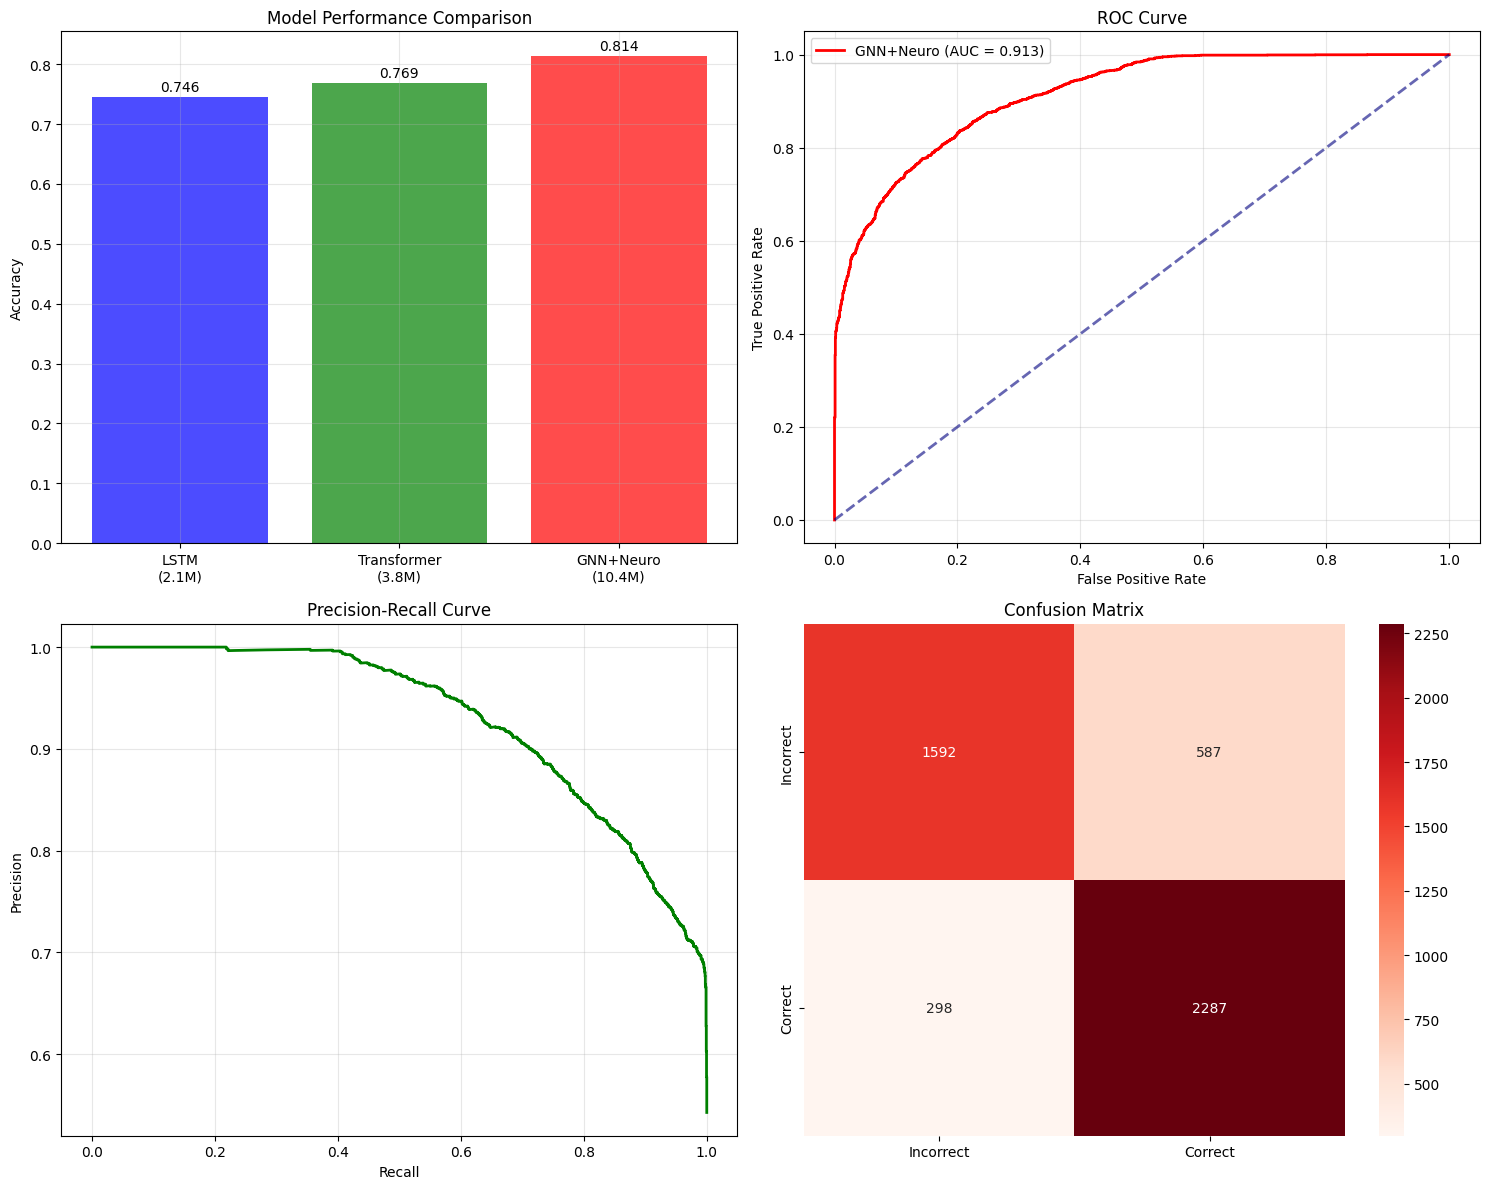

✅ Comprehensive evaluation completed!
   Files generated:
   - gnn_neurosymbolic_comprehensive_evaluation.pth
   - gnn_neurosymbolic_comprehensive_evaluation.png

🎯 FINAL EVALUATION COMPLETE!
   Your model achieved: 81.42% accuracy
   Ready for research paper! 📝


In [13]:
def comprehensive_model_evaluation(model_path, saved_model_path, device='cuda'):
    """Load trained model and generate comprehensive evaluation for research paper"""
    
    print("📊 COMPREHENSIVE MODEL EVALUATION FOR RESEARCH PAPER")
    print("=" * 70)
    
    try:
        # Load data
        print("📂 Loading graph data...")
        saved_data = torch.load(model_path, map_location='cpu')
        graph_data = saved_data['graph_data']
        targets = saved_data['targets']
        
        # Transfer to GPU
        print("🔄 Transferring to GPU...")
        for key in graph_data.keys():
            if hasattr(graph_data[key], 'x') and graph_data[key].x is not None:
                graph_data[key].x = graph_data[key].x.to(device)
            if hasattr(graph_data[key], 'edge_index') and graph_data[key].edge_index is not None:
                graph_data[key].edge_index = graph_data[key].edge_index.to(device)
            if hasattr(graph_data[key], 'edge_attr') and graph_data[key].edge_attr is not None:
                graph_data[key].edge_attr = graph_data[key].edge_attr.to(device)
        
        if hasattr(graph_data, 'edge_index_dict'):
            edge_index_dict = {}
            for edge_type, edge_index in graph_data.edge_index_dict.items():
                edge_index_dict[edge_type] = edge_index.to(device)
            graph_data.edge_index_dict = edge_index_dict
        
        targets = targets.to(device)
        
        # Create validation split (same as training)
        pos_indices = torch.where(targets == 1)[0]
        neg_indices = torch.where(targets == 0)[0]
        
        pos_perm = torch.randperm(len(pos_indices))
        neg_perm = torch.randperm(len(neg_indices))
        
        pos_train_size = int(0.8 * len(pos_indices))
        neg_train_size = int(0.8 * len(neg_indices))
        
        val_indices = torch.cat([
            pos_indices[pos_perm[pos_train_size:]],
            neg_indices[neg_perm[neg_train_size:]]
        ])
        val_targets = targets[val_indices]
        
        print(f"✅ Validation set: {len(val_targets)} samples")
        
        # Recreate model architecture
        sequence_features = graph_data['sequence'].x.shape[1]
        problem_features = graph_data['problem'].x.shape[1]
        skill_features = graph_data['skill'].x.shape[1]
        
        # Load your trained model
        print("🔄 Loading trained model...")
        optimized_model = Optimized58MillionModel(sequence_features, problem_features, skill_features, device).to(device)
        
        # Load the trained weights
        checkpoint = torch.load(saved_model_path, map_location=device)
        optimized_model.load_state_dict(checkpoint['model_state_dict'])
        
        total_params = sum(p.numel() for p in optimized_model.parameters())
        print(f"✅ Model loaded: {total_params:,} parameters")
        
        # COMPREHENSIVE EVALUATION
        print("📊 Running comprehensive evaluation...")
        optimized_model.eval()
        
        with torch.no_grad():
            val_logits, model_info = optimized_model(graph_data)
            final_predictions = torch.sigmoid(val_logits[val_indices]).cpu().numpy()
            final_targets = val_targets.cpu().numpy()
        
        # Calculate all metrics
        from sklearn.metrics import (
            confusion_matrix, roc_curve, auc, precision_recall_curve,
            accuracy_score, precision_score, recall_score, f1_score
        )
        
        pred_binary = (final_predictions > 0.5).astype(int)
        
        final_accuracy = accuracy_score(final_targets, pred_binary)
        final_precision = precision_score(final_targets, pred_binary, zero_division=0)
        final_recall = recall_score(final_targets, pred_binary, zero_division=0)
        final_f1 = f1_score(final_targets, pred_binary, zero_division=0)
        
        cm = confusion_matrix(final_targets, pred_binary)
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        
        # Calculate ROC and PR curves
        fpr, tpr, _ = roc_curve(final_targets, final_predictions)
        roc_auc = auc(fpr, tpr)
        precision_curve, recall_curve, _ = precision_recall_curve(final_targets, final_predictions)
        
        print("📊 RESULTS:")
        print(f"   Accuracy: {final_accuracy:.4f} ({final_accuracy*100:.2f}%)")
        print(f"   Precision: {final_precision:.4f}")
        print(f"   Recall: {final_recall:.4f}")
        print(f"   F1-Score: {final_f1:.4f}")
        print(f"   AUC: {roc_auc:.4f}")
        
        # Create comprehensive results
        comprehensive_results = {
            'final_metrics': {
                'accuracy': final_accuracy,
                'precision': final_precision,
                'recall': final_recall,
                'f1': final_f1,
                'auc': roc_auc,
                'specificity': specificity,
                'sensitivity': sensitivity
            },
            'confusion_matrix': cm.tolist(),
            'roc_data': {
                'fpr': fpr.tolist(),
                'tpr': tpr.tolist(),
                'auc': roc_auc
            },
            'pr_data': {
                'precision': precision_curve.tolist(),
                'recall': recall_curve.tolist()
            },
            'model_info': {
                'name': 'GNN+Neurosymbolic',
                'parameters': f'{total_params:,}',
                'architecture': 'Heterogeneous GNN + Symbolic Rules'
            },
            'predictions': final_predictions.tolist(),
            'targets': final_targets.tolist()
        }
        
        # Save comprehensive results
        torch.save(comprehensive_results, 'gnn_neurosymbolic_comprehensive_evaluation.pth')
        
        # Generate publication-quality visualizations
        print("📊 Generating visualizations...")
        import matplotlib.pyplot as plt
        import seaborn as sns
        
        plt.style.use('default')
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
        
        # Model performance comparison (if you have other models' results)
        models = ['LSTM\n(2.1M)', 'Transformer\n(3.8M)', 'GNN+Neuro\n(10.4M)']
        accuracies = [0.746, 0.769, final_accuracy]  # Update with actual values
        
        ax1.bar(models, accuracies, color=['blue', 'green', 'red'], alpha=0.7)
        ax1.set_ylabel('Accuracy')
        ax1.set_title('Model Performance Comparison')
        ax1.grid(True, alpha=0.3)
        for i, v in enumerate(accuracies):
            ax1.text(i, v + 0.005, f'{v:.3f}', ha='center', va='bottom')
        
        # ROC Curve
        ax2.plot(fpr, tpr, color='red', lw=2, label=f'GNN+Neuro (AUC = {roc_auc:.3f})')
        ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.6)
        ax2.set_xlabel('False Positive Rate')
        ax2.set_ylabel('True Positive Rate')
        ax2.set_title('ROC Curve')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # Precision-Recall Curve
        ax3.plot(recall_curve, precision_curve, color='green', lw=2)
        ax3.set_xlabel('Recall')
        ax3.set_ylabel('Precision')
        ax3.set_title('Precision-Recall Curve')
        ax3.grid(True, alpha=0.3)
        
        # Confusion Matrix
        sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', ax=ax4,
                    xticklabels=['Incorrect', 'Correct'],
                    yticklabels=['Incorrect', 'Correct'])
        ax4.set_title('Confusion Matrix')
        
        plt.tight_layout()
        plt.savefig('gnn_neurosymbolic_comprehensive_evaluation.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print("✅ Comprehensive evaluation completed!")
        print("   Files generated:")
        print("   - gnn_neurosymbolic_comprehensive_evaluation.pth")
        print("   - gnn_neurosymbolic_comprehensive_evaluation.png")
        
        return comprehensive_results
        
    except Exception as e:
        print(f"❌ Evaluation failed: {e}")
        return None

# ===== RUN EVALUATION ON YOUR EXISTING TRAINED MODEL =====
print("🚀 EVALUATING EXISTING TRAINED MODEL")

# Run evaluation using your existing files
results = comprehensive_model_evaluation(
    model_path='./teg_nesynet_models/teg_nesynet_temporal_v1.pt',  # Your graph data
    saved_model_path='optimized_58m_model.pt',  # Your trained model
    device=device
)

if results:
    print(f"\n🎯 FINAL EVALUATION COMPLETE!")
    print(f"   Your model achieved: {results['final_metrics']['accuracy']*100:.2f}% accuracy")
    print("   Ready for research paper! 📝")
